In [ ]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import psycopg2
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

In [15]:
# Connect to postgis database, read in tables as geopandas geodataframes
load_dotenv()

conn = psycopg2.connect(dbname="spatial_db", user=os.getenv('DB_USERNAME'), password=os.getenv('DB_PASSWORD'), host="localhost", port="5432")

states_query = 'SELECT * FROM "States";'
parcels_query = 'SELECT * FROM "Missoula_Parcels";'
nwa_query = 'SELECT * FROM "National_Wilderness_Areas";'
trails_query = 'SELECT * FROM "Trails";'

states_gdf = gpd.read_postgis(states_query, conn, geom_col="geom")
parcels_gdf = gpd.read_postgis(parcels_query, conn, geom_col="geom")
nwa_gdf = gpd.read_postgis(nwa_query, conn, geom_col="geom")
trails_gdf = gpd.read_postgis(trails_query, conn, geom_col="geom")

conn.close()

In [28]:
# Select Montana from States GDF, set all GDF to EPSG 6514, subset nwa_gdf to only Montana
montana_gdf = states_gdf[states_gdf["state"] == 'MT']
montana_gdf = montana_gdf.to_crs(epsg=6514)
trails_gdf = trails_gdf.to_crs(epsg=6514)
nwa_gdf = nwa_gdf.to_crs(epsg=6514)
nwa_montana_gdf = gpd.overlay(nwa_gdf, montana_gdf, how="intersection")

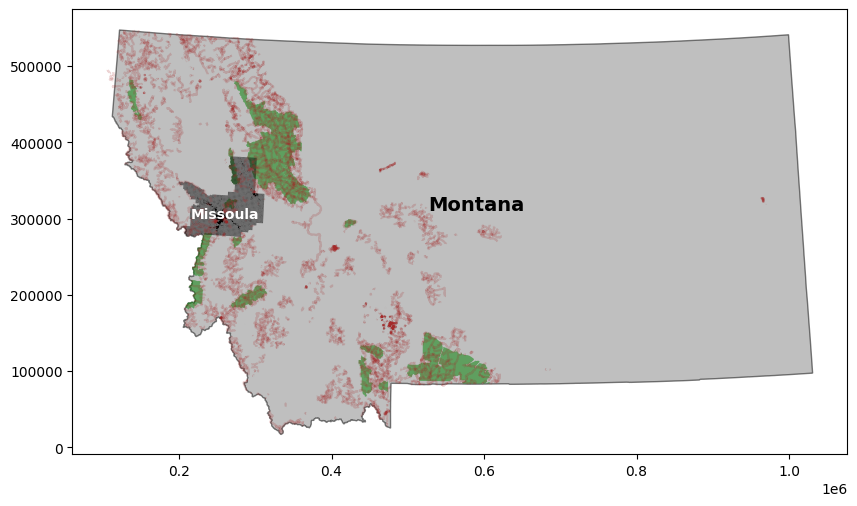

In [51]:
# Map montana_gdf, trails_gdf, and parcels_gdf to validate CRS
fig, ax = plt.subplots(figsize=(10, 10))

montana_gdf.plot(ax=ax, color='gray', edgecolor='black', alpha=0.5)
montana_gdf.apply(
    lambda x: ax.annotate(
        text=x['name'], 
        xy=x.geom.centroid.coords[0], 
        ha='center',
        weight='bold',
        fontsize=14
    ), 
    axis=1
)

ax.annotate('Missoula', (260000, 300000), color='white', ha='center', weight='bold')

nwa_montana_gdf.plot(ax=ax, color='green', alpha=0.5)
trails_gdf.plot(ax=ax, color='brown', alpha=0.2)
parcels_gdf.plot(ax=ax, color='black', alpha=0.5)

plt.show()

In [105]:
# Select only NWA polygons and trails intersecting Missoula county, dissolve NWA to fix cuts
trails_missoula_gdf = gpd.overlay(trails_gdf, parcels_gdf, how="intersection")
trails_missoula_gdf = trails_missoula_gdf.reset_index(drop=True)

nwa_missoula_cuts_gdf = gpd.overlay(nwa_gdf, parcels_gdf, how="intersection")
nwa_missoula_cuts_gdf = nwa_missoula_cuts_gdf.reset_index(drop=True)

nwa_missoula_gdf = nwa_missoula_cuts_gdf.dissolve(by="WILDERNESSNAME")
nwa_missoula_gdf = nwa_missoula_gdf.reset_index()

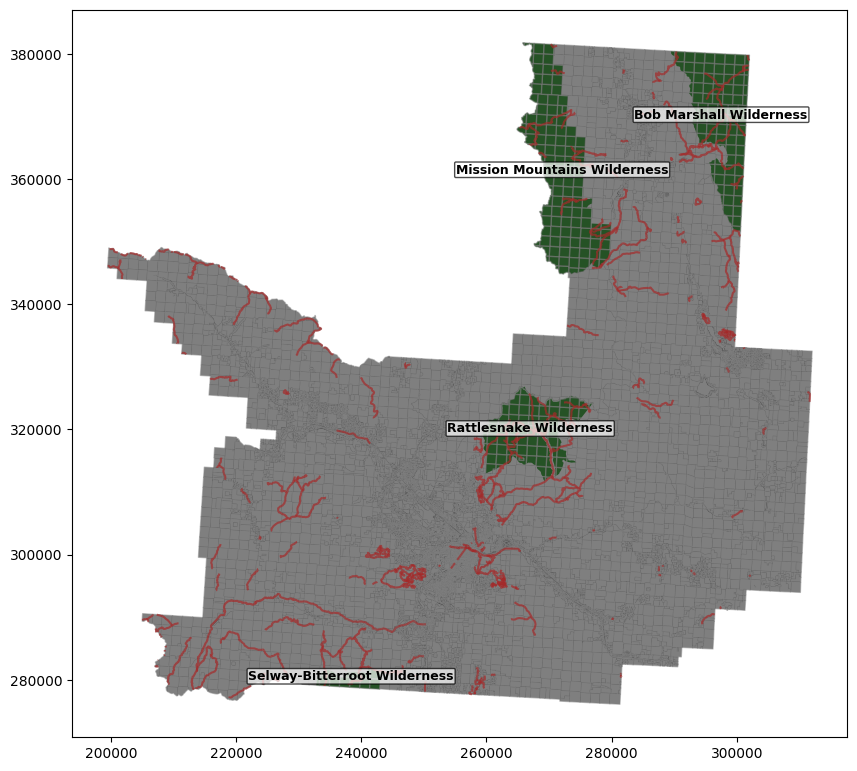

In [106]:
# Plot newly subsetted data
fig, ax = plt.subplots(figsize=(10, 10))

nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.7)
nwa_missoula_gdf.apply(
    lambda x: ax.annotate(
        text=x['WILDERNESSNAME'], 
        xy=x.geometry.centroid.coords[0], 
        ha='center',
        weight='bold',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle="round,pad=0.1")
    ), 
    axis=1
)

trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)

plt.show()

In [107]:
# Make parcel subsets: parcels that intersect trails, NWA, and both
parcels_trails_gdf = gpd.sjoin(parcels_gdf, trails_missoula_gdf, how="inner", predicate="intersects", lsuffix="_left", rsuffix="_right")
parcels_trails_gdf = parcels_trails_gdf.reset_index()

parcels_nwa_gdf = gpd.sjoin(parcels_gdf, nwa_missoula_gdf, how="inner", predicate="intersects", lsuffix="_left", rsuffix="_right")
parcels_nwa_gdf = parcels_nwa_gdf.reset_index()

parcels_trails_nwa_gdf = gpd.sjoin(parcels_nwa_gdf, trails_missoula_gdf, predicate="intersects")
parcels_trails_nwa_gdf = parcels_trails_nwa_gdf.reset_index()

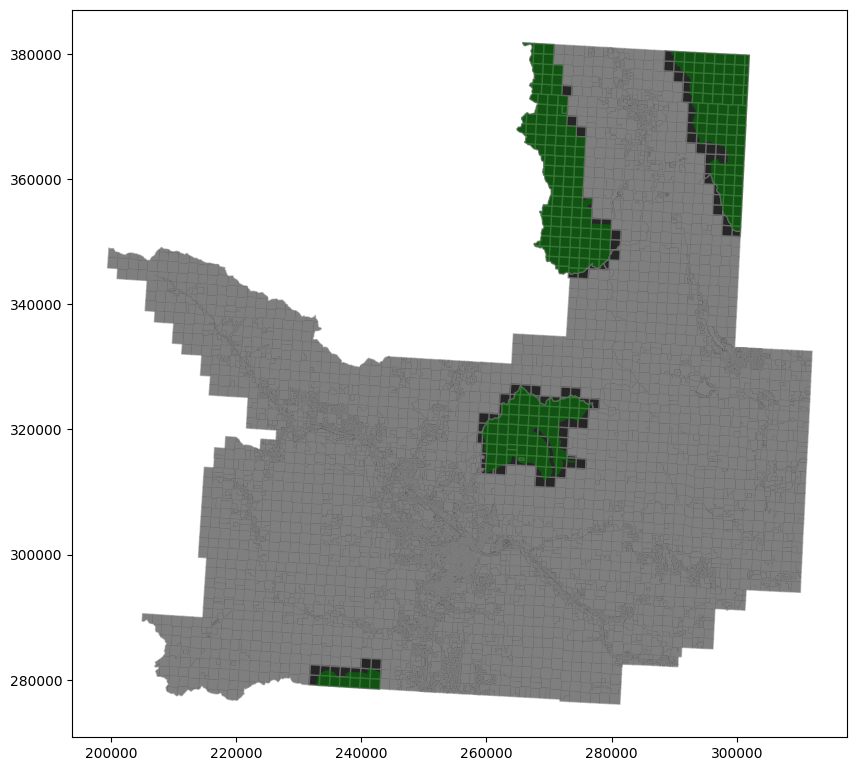

In [108]:
# Plot subsetted NWA parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_nwa_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.5)

plt.show()

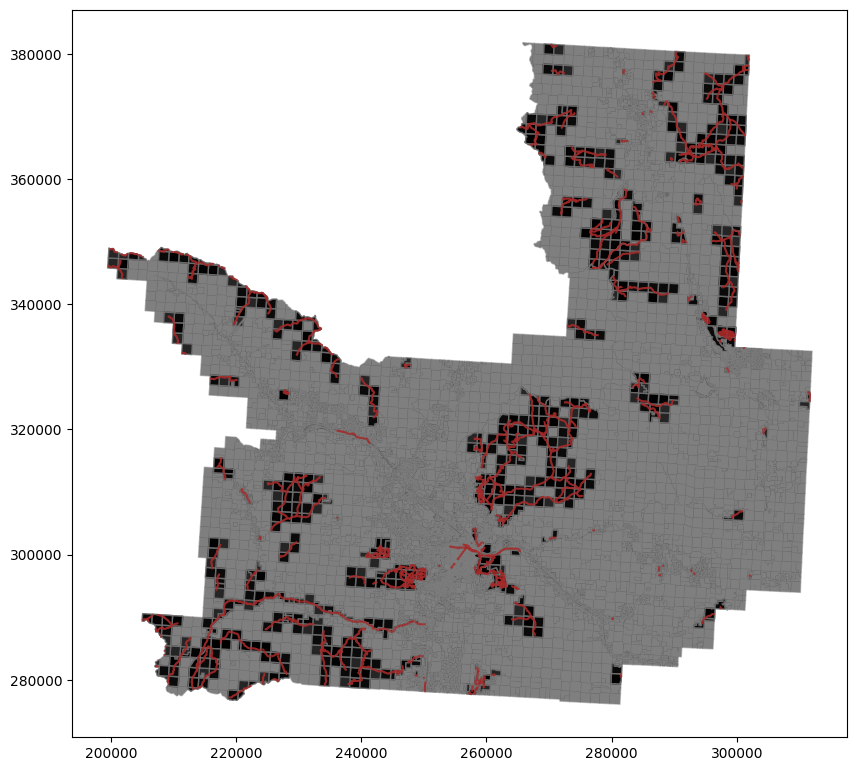

In [109]:
# Plot subsetted trail parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_trails_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)

plt.show()

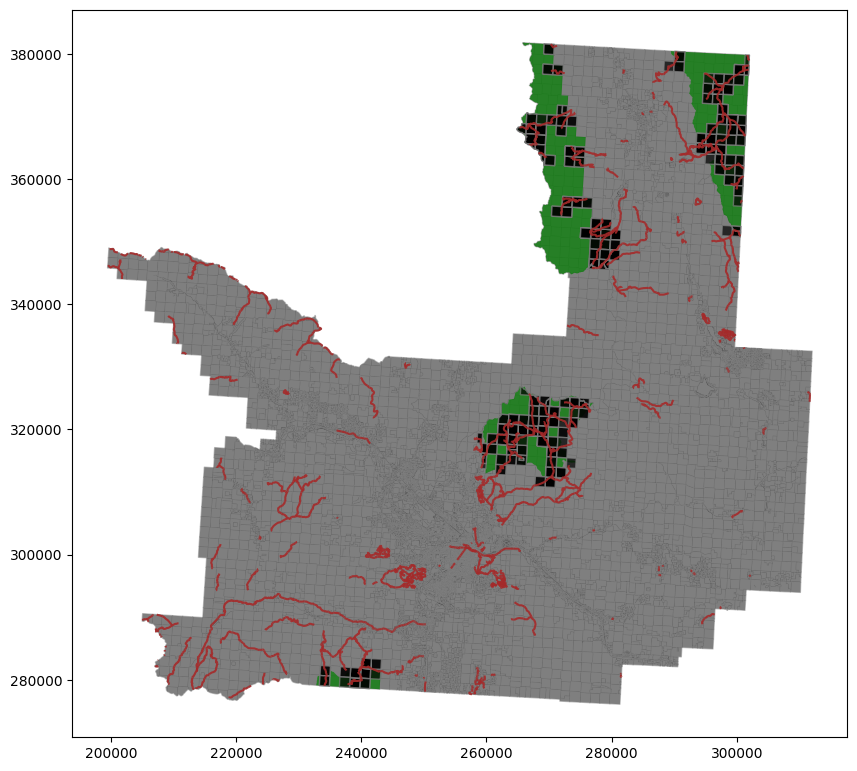

In [110]:
# Plot subsetted trail/NWA parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)
nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.7)
parcels_trails_nwa_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)

plt.show()

In [111]:
# Make inverse of parcel subsets
parcels_not_trails_gdf = parcels_gdf[~parcels_gdf.index.isin(parcels_trails_gdf.index)]
parcels_not_nwa_gdf = parcels_gdf[~parcels_gdf.index.isin(parcels_nwa_gdf.index)]
parcels_not_trails_nwa_gdf = parcels_gdf[~parcels_gdf.index.isin(parcels_trails_nwa_gdf.index)]

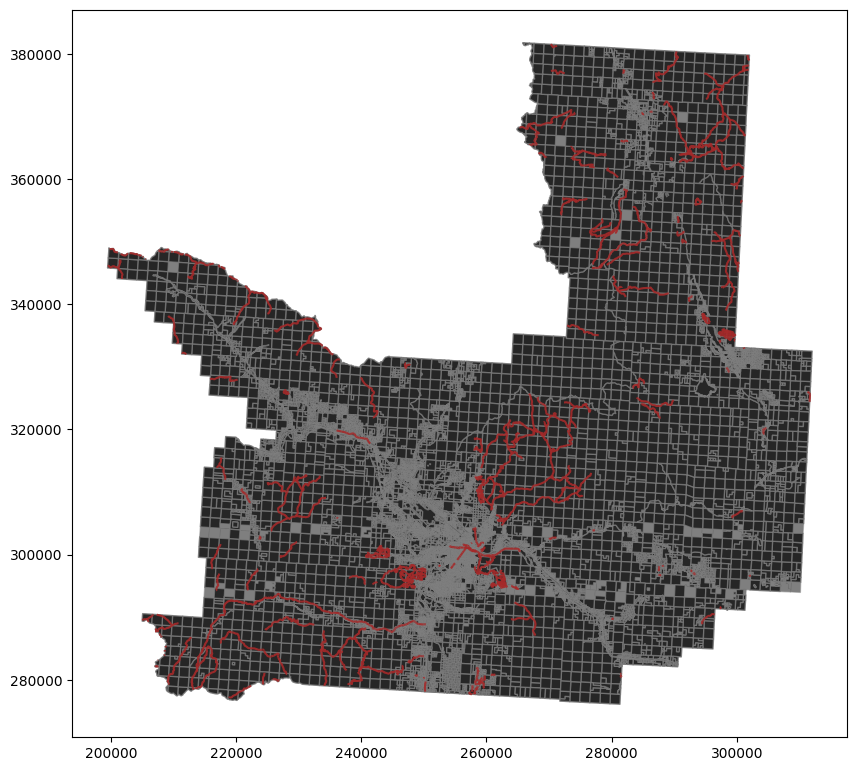

In [115]:
# Plot subsetted trail/NWA parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)
parcels_not_trails_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)

plt.show()

In [120]:
parcels_not_nwa_gdf.to_file("parcels_not_nwa_gdf.shp", driver="ESRI Shapefile")

In [114]:
print("Total parcels:", parcels_gdf.shape[0])
print("Trails + Not Trails:", parcels_trails_gdf.shape[0] + parcels_not_trails_gdf.shape[0])
print("Trails+NWA + Not Trails+NWA:", parcels_trails_nwa_gdf.shape[0] + parcels_not_trails_nwa_gdf.shape[0])
print("NWA + Not NWA:", parcels_nwa_gdf.shape[0] + parcels_not_nwa_gdf.shape[0])


Total parcels: 57458
Trails + Not Trails: 57458
Trails+NWA + Not Trails+NWA: 57458
NWA + Not NWA: 57458
